Création de bruits

In [ ]:
import random
import cv2
def add_noise(img):
     # Getting the dimensions of the image
    row , col = img.shape
    # Randomly pick some pixels in the
    # image for coloring them white
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300, 10000)
    for i in range(number_of_pixels):
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1)
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1)
        # Color that pixel to white
        img[y_coord][x_coord] = 255
    # Randomly pick some pixels in
    # the image for coloring them black
    # Pick a random number between 300 and 10000
    number_of_pixels = random.randint(300 , 10000)
    for i in range(number_of_pixels):
        # Pick a random y coordinate
        y_coord=random.randint(0, row - 1) 
        # Pick a random x coordinate
        x_coord=random.randint(0, col - 1) 
        # Color that pixel to black
        img[y_coord][x_coord] = 0  
    return img

# Reading the color image in grayscale image
img = cv2.imread('Y1.jpg',cv2.IMREAD_GRAYSCALE)
#Storing the image
cv2.imwrite('Y1_SP.jpg', add_noise(img))

Filtrage images

In [8]:
import numpy as np
import os
import cv2
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.004
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss
      return noisy
   
my_img = cv2.imread('Y1.jpg')
cv2.imwrite('Y1_gauss.jpg', noisy("gauss",my_img))

True

c:\Users\arthu\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
C:\Users\arthu\AppData\Local\Temp\ipykernel_56860\2529883491.py:83: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss1,PSNR(original,blurred_img1),ssim_gauss1))
C:\Users\arthu\AppData\Local\Temp\ipykernel_56860\2529883491.py:87: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med1,PSNR(original,median_img1),ssim_med1))
C:\Users\arthu\AppData\Local\Temp\ipykernel_56860\2529883491.py:91: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni1,PSNR(original,uniform_filtered_img1),ssim_uni1))
C:\

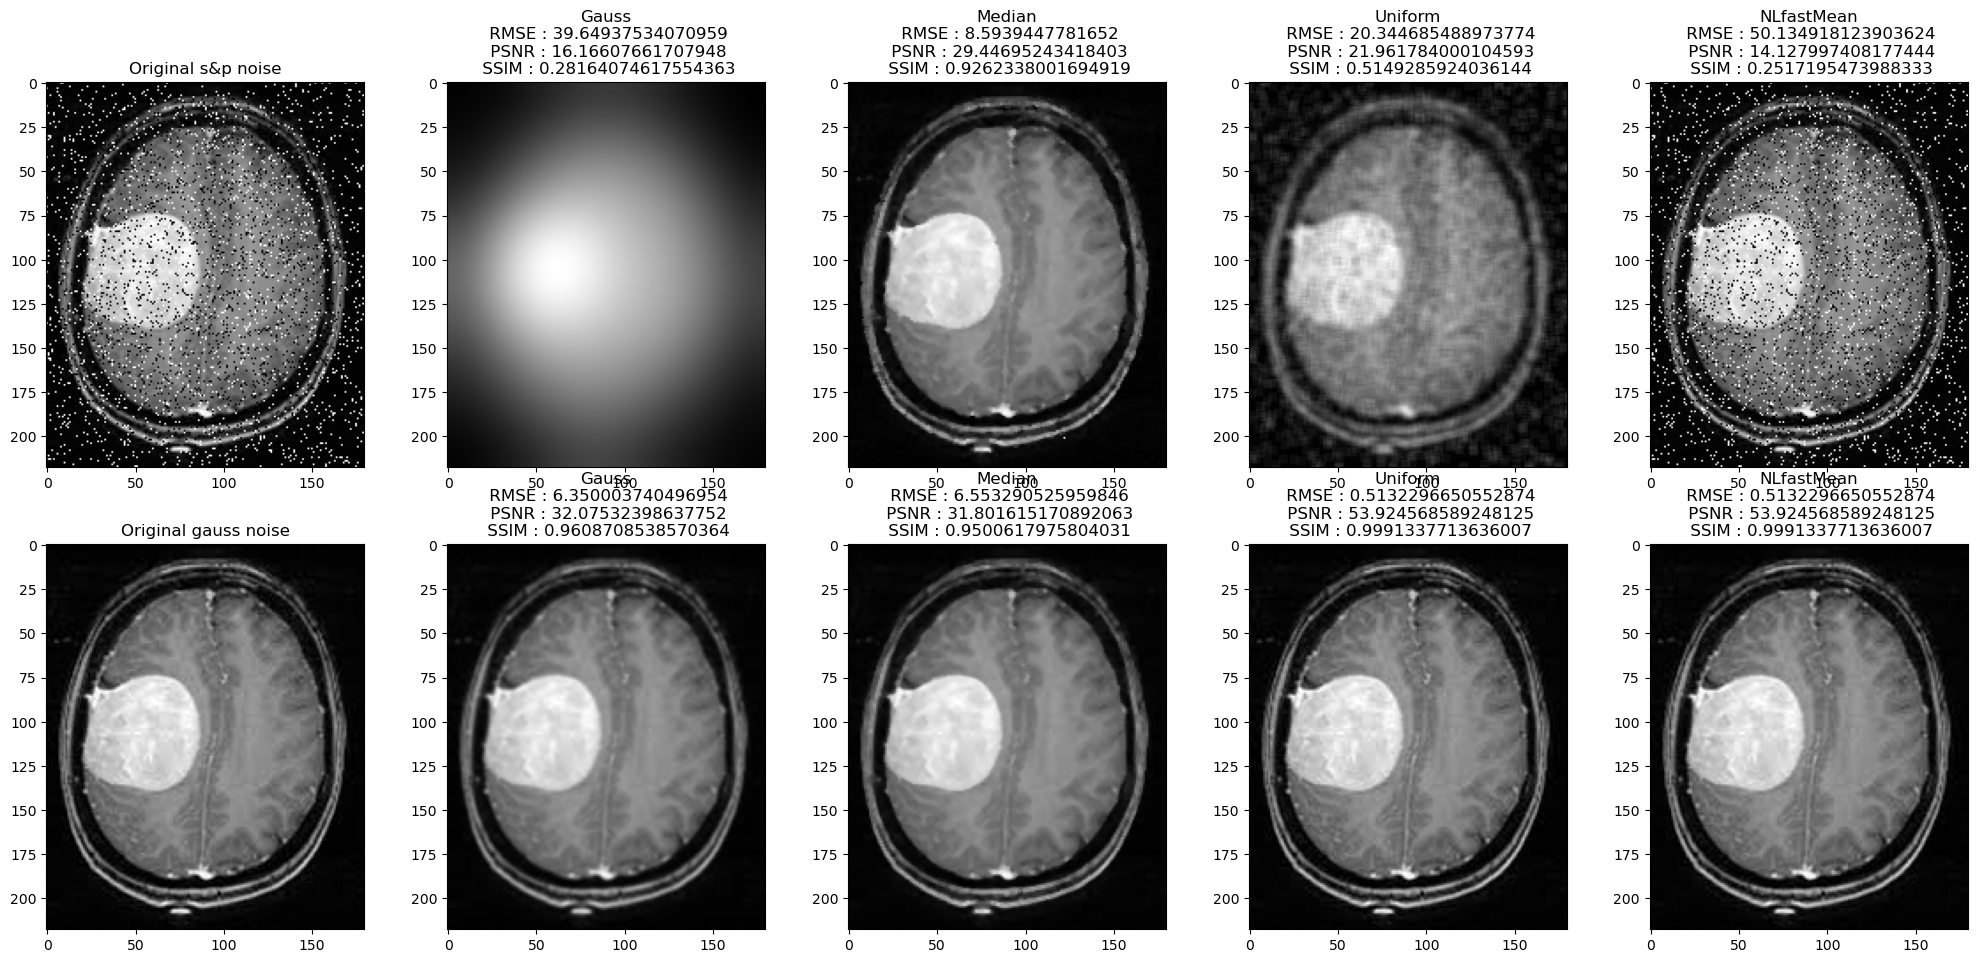

True

In [15]:
from skimage import io, img_as_ubyte
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
import math
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.restoration import denoise_wavelet, denoise_nl_means, estimate_sigma
import cv2
# Fonction pour le calcul du root mean square ratio (RMSE)
def RMSE(imageA, imageB):
    diffrnce = np.subtract(imageA, imageB)
    sqre_err = np.square(diffrnce)
    rslt_meansqre_err = sqre_err.mean()
    root_meansqre_err = math.sqrt(rslt_meansqre_err)
    return root_meansqre_err

# Ouverture de l'image bruit s&p
img1 = cv2.imread("Y1_SP.jpg", 0)
img1 = img1.astype(float)
# Ouverture de l'image bruit gaussien
img2 = cv2.imread("Y1_gauss.jpg", 0)
img2 = img2.astype(float)

# Ouverture de l'image original
original=cv2.imread("Y1.jpg", 0)

# Estimation du bruit de l'image
noise1 = estimate_sigma(img1)
noise2 = estimate_sigma(img2)

# Application d'un filtre uniforme
uniform_filtered_img1 = ndimage.uniform_filter(img1, size=5)
uniform_filtered_img2 = ndimage.uniform_filter(img2, size=1)

# Application d'un filtre gaussien
# Le filtre gaussian effectue une moyenne pondérée des valeurs du voisinage avec des poids élevés vers le centre puis qui diminue en s'écartant.
blurred_img1 = ndimage.gaussian_filter(img1, sigma=noise1)  
blurred_img2 = ndimage.gaussian_filter(img2, sigma=noise2)

# Application d'un filtre médian
# Fonctionnement filtre médian : Remplace l'entrée par la valeur médiane de ces voisins (window : généralement 3)
median_img1 = ndimage.median_filter(img1, 3)
median_img2 = ndimage.median_filter(img2, 3)

# Application d'un filtre moyen non local
# Fonction filtre nl_means : Prend le moyenne de l'ensemble des patchs de l'image, puis les pondère en fonction de la ressemblance avec le pixel cible
dst1 = denoise_nl_means(img1, patch_size=3)
dst2 = denoise_nl_means(img2, patch_size=3)

# Calcul du RMSE pour l'ensemble des images filtrées
RMSE_gauss1=RMSE(original, blurred_img1)
RMSE_gauss2=RMSE(original, blurred_img2)
RMSE_med1=RMSE(original, median_img1)
RMSE_med2=RMSE(original, median_img2)
RMSE_uni1=RMSE(original, uniform_filtered_img1)
RMSE_uni2=RMSE(original, uniform_filtered_img2)
RMSE_dst1=RMSE(original, dst1)
RMSE_dst2=RMSE(original, dst2)

# Calcul du "structural similarity index measure" (SSIM) pour l'ensemble des images filtrées
ssim_gauss1=ssim(original,blurred_img1)
ssim_gauss2=ssim(original,blurred_img2)
ssim_med1=ssim(original,median_img1)
ssim_med2=ssim(original,median_img2)
ssim_uni1=ssim(original,uniform_filtered_img1)
ssim_uni2=ssim(original,uniform_filtered_img2)
ssim_dst1=ssim(original,dst1)
ssim_dst2=ssim(original,dst2)

# Affichage de l'ensemble des images avec les métriques
fig = plt.figure()
fig.set_figheight(11)
fig.set_figwidth(25)

fig.add_subplot(2,5,1)
plt.imshow(img1, cmap='gray')
plt.title('Original s&p noise')

fig.add_subplot(2,5,2)
plt.imshow(blurred_img1, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss1,PSNR(original,blurred_img1),ssim_gauss1))
###
fig.add_subplot(2,5,3)
plt.imshow(median_img1, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med1,PSNR(original,median_img1),ssim_med1))
###
fig.add_subplot(2,5,4)
plt.imshow(uniform_filtered_img1, cmap='gray')
plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni1,PSNR(original,uniform_filtered_img1),ssim_uni1))
###
fig.add_subplot(2,5,5)
plt.imshow(dst1, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst1,PSNR(original,dst1),ssim_dst1))

fig.add_subplot(2,5,6)
plt.imshow(img2, cmap='gray')
plt.title('Original gauss noise')

fig.add_subplot(2,5,7)
plt.imshow(blurred_img2, cmap='gray')
plt.title("Gauss\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_gauss2,PSNR(original,blurred_img2),ssim_gauss2))

fig.add_subplot(2,5,8)
plt.imshow(median_img2, cmap='gray')
plt.title("Median\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_med2,PSNR(original,median_img2),ssim_med2))
######
fig.add_subplot(2,5,9)
plt.imshow(uniform_filtered_img2, cmap='gray')
plt.title("Uniform\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_uni2,PSNR(original,uniform_filtered_img2),ssim_uni2))
######
fig.add_subplot(2,5,10)
plt.imshow(dst2, cmap='gray')
plt.title("NLfastMean\n RMSE : {}\n PSNR : {}\n SSIM : {}".format(RMSE_dst2,PSNR(original,dst2),ssim_dst2))
plt.show()

cv2.imwrite('Y1_SP_filtered.jpg', median_img1)
cv2.imwrite('Y1_gauss_filtered.jpg', uniform_filtered_img2)

Réhaussement de contraste

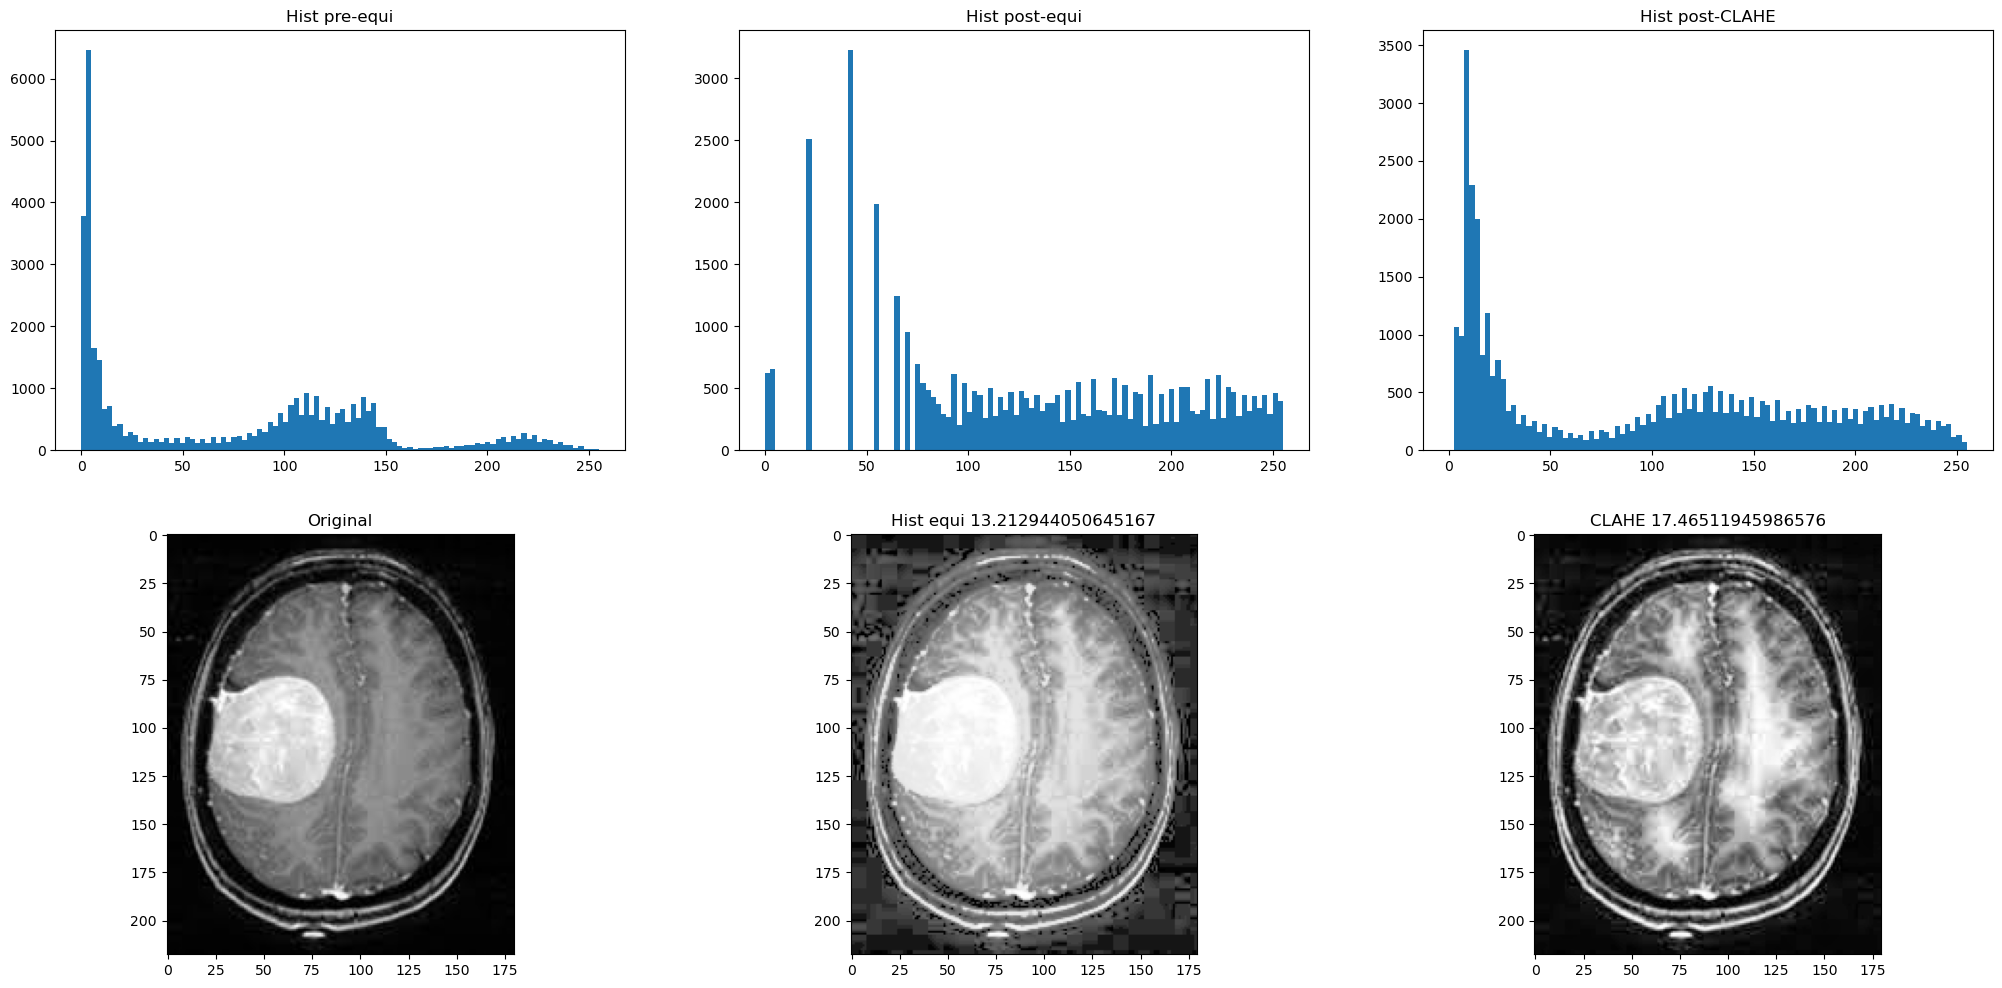

True

In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as PSNR

# On ouvre l'image "Torse"
img = cv2.imread("Y1_gauss_filtered.jpg", 0)
# Application d'un équalisateur d'histogramme
# Il redonne via une formule mathématique une valeur pour chaque pixel afin d'utiliser l'ensemble des valeurs de pixel de manière la plus équitable possible
equ = cv2.equalizeHist(img)
# Application d'un CLAHE
# Contrast Limited Adaptive Histogram Equalization (CLAHE) : l'image est divisés en blocs sur lequels une équalisation d'histogramme est effectué.
# Une limite de contrast est aussi définie. Si une case de l'histogramme dépasse le valeur limite alors les valeurs en excès sont accumulées et redistribuées dans d'autres cases
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
cl1 = clahe.apply(img)
# Affichage de l'ensemble des images avec les métriques
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(25)

fig.add_subplot(2,3,1)
plt.hist(img.flat, bins=100, range=(0,255))
plt.title('Hist pre-equi')

fig.add_subplot(2,3,2)
plt.hist(equ.flat, bins=100, range=(0,255))
plt.title('Hist post-equi')

fig.add_subplot(2,3,3)
plt.hist(cl1.flat, bins=100, range=(0,255))
plt.title('Hist post-CLAHE')

fig.add_subplot(2,3,4)
plt.imshow(img, cmap='gray')
plt.title('Original')

fig.add_subplot(2,3,5)
plt.imshow(equ, cmap='gray')
plt.title('Hist equi {}'.format(PSNR(img,equ)))

fig.add_subplot(2,3,6)
plt.imshow(cl1, cmap='gray')
plt.title('CLAHE {}'.format(PSNR(img,cl1)))

plt.show()
cv2.imwrite('Y1_gauss_clh.jpg', cl1)
#cv2.imwrite('Cancer_enh.png',cl1)


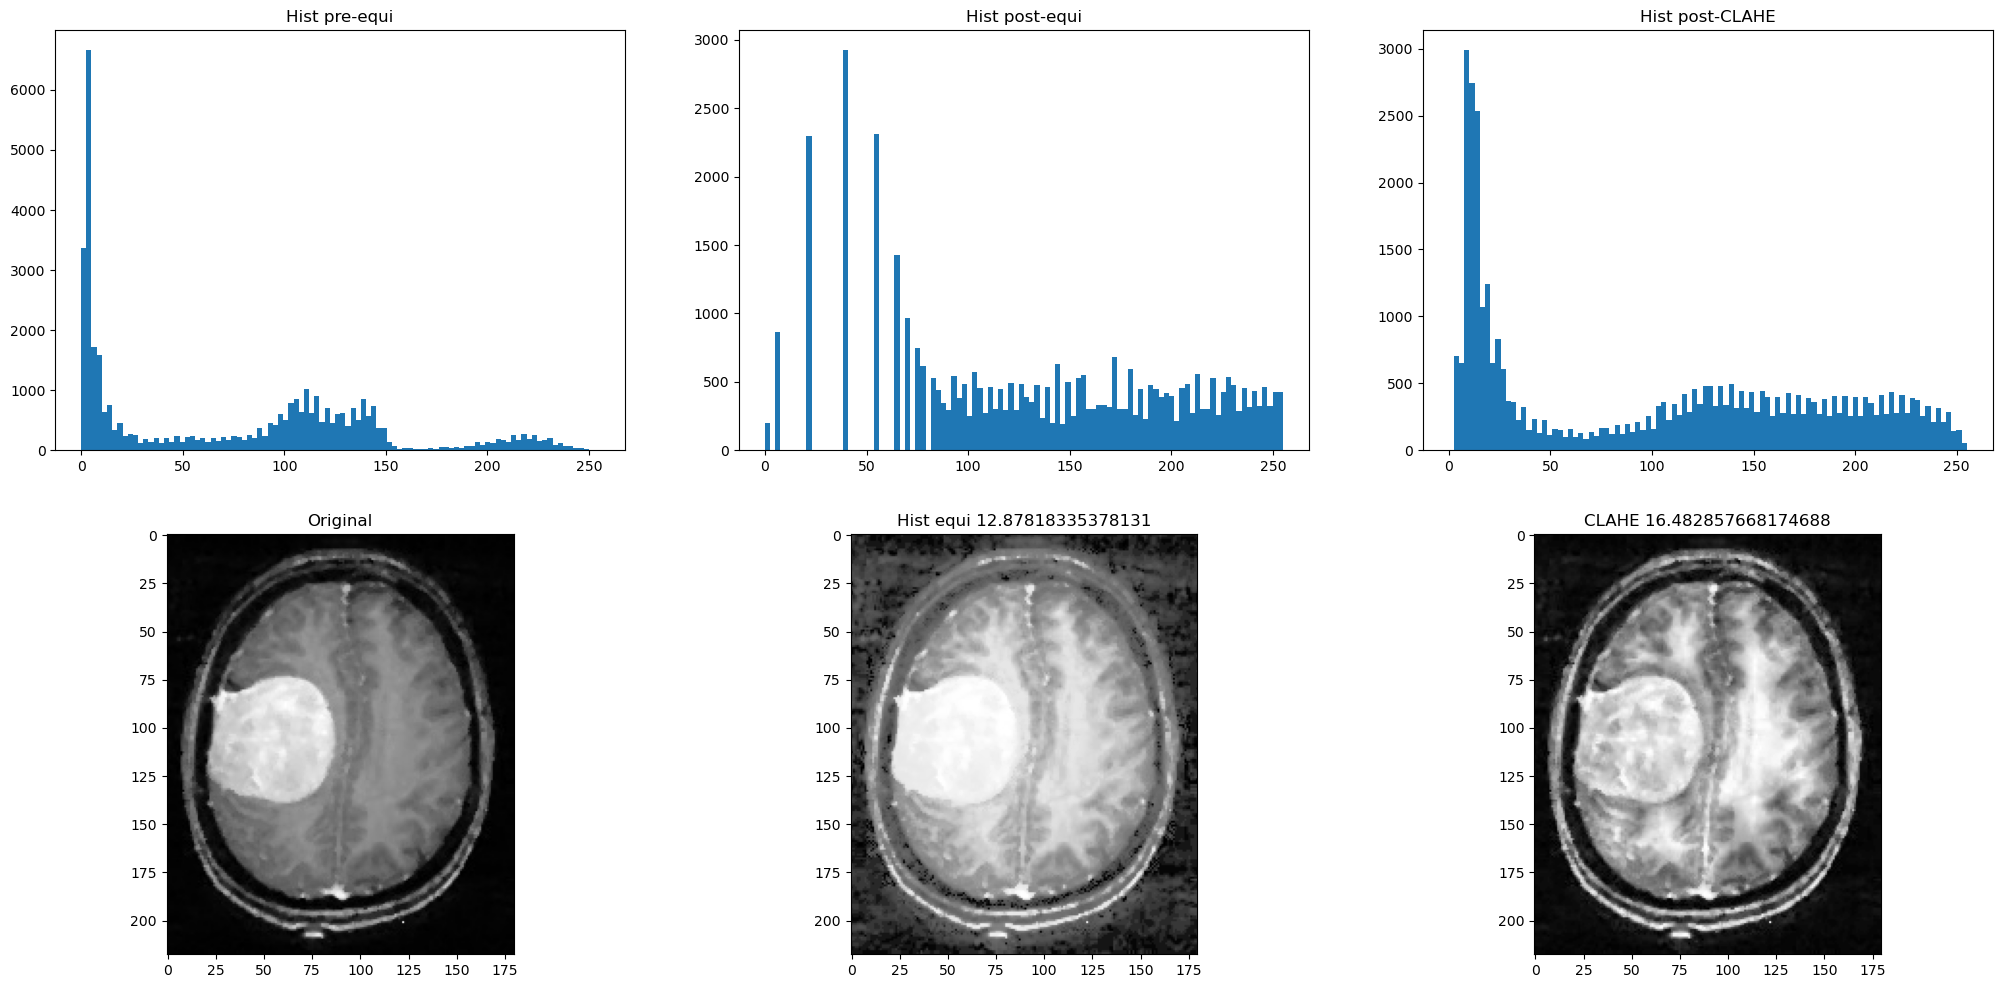

True

In [52]:
# On ouvre l'image "Torse"
img = cv2.imread("Y1_SP_filtered.jpg", 0)
# Application d'un équalisateur d'histogramme
# Il redonne via une formule mathématique une valeur pour chaque pixel afin d'utiliser l'ensemble des valeurs de pixel de manière la plus équitable possible
equ = cv2.equalizeHist(img)
# Application d'un CLAHE
# Contrast Limited Adaptive Histogram Equalization (CLAHE) : l'image est divisés en blocs sur lequels une équalisation d'histogramme est effectué.
# Une limite de contrast est aussi définie. Si une case de l'histogramme dépasse le valeur limite alors les valeurs en excès sont accumulées et redistribuées dans d'autres cases
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
cl1 = clahe.apply(img)
# Affichage de l'ensemble des images avec les métriques
fig = plt.figure()
fig.set_figheight(12)
fig.set_figwidth(25)

fig.add_subplot(2,3,1)
plt.hist(img.flat, bins=100, range=(0,255))
plt.title('Hist pre-equi')

fig.add_subplot(2,3,2)
plt.hist(equ.flat, bins=100, range=(0,255))
plt.title('Hist post-equi')

fig.add_subplot(2,3,3)
plt.hist(cl1.flat, bins=100, range=(0,255))
plt.title('Hist post-CLAHE')

fig.add_subplot(2,3,4)
plt.imshow(img, cmap='gray')
plt.title('Original')

fig.add_subplot(2,3,5)
plt.imshow(equ, cmap='gray')
plt.title('Hist equi {}'.format(PSNR(img,equ)))

fig.add_subplot(2,3,6)
plt.imshow(cl1, cmap='gray')
plt.title('CLAHE {}'.format(PSNR(img,cl1)))

plt.show()
cv2.imwrite('Y1_SP_clh.jpg', cl1)
        

Segmentation Threshold

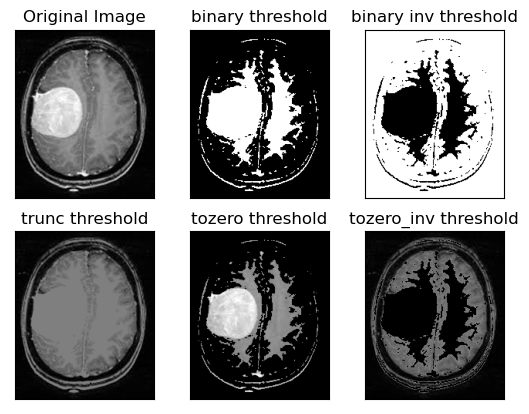

In [16]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread("Y1_gauss_filtered.jpg", 0)
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)
titles = ['Original Image','binary threshold','binary inv threshold','trunc threshold','tozero threshold',
          'tozero_inv threshold']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

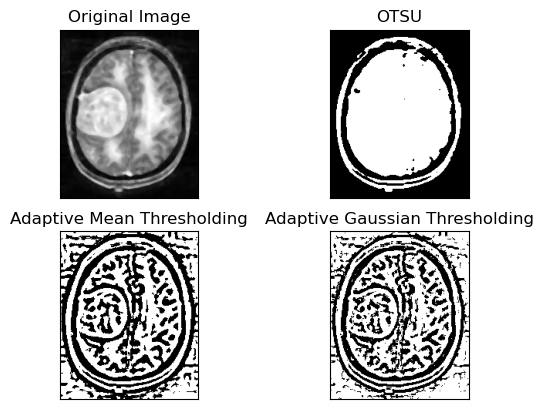

In [56]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread("Y1_gauss_clh.jpg", 0)
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,0,255,cv.THRESH_OTSU)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'OTSU',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

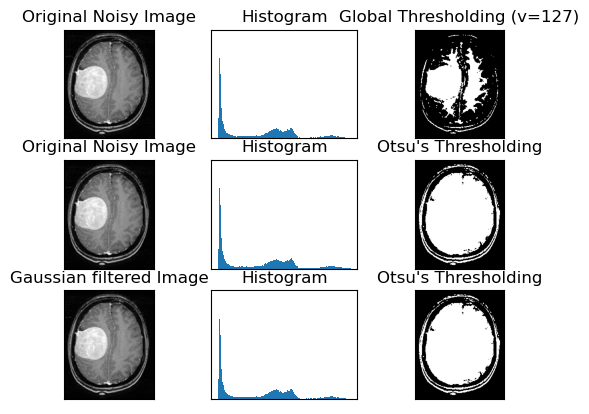

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 127.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 74.0
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 74.0


In [40]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread("Y1_gauss_filtered.jpg", 0)
# global thresholding
ret1,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
# Otsu's thresholding
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_OTSU)
ret3,th3 = cv.threshold(img,0,255,cv.THRESH_OTSU)
# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          img, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()
print( "{} {}".format(th1,ret1))
print( "{} {}".format(th2,ret2) )
print( "{} {}".format(th3,ret3) )

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


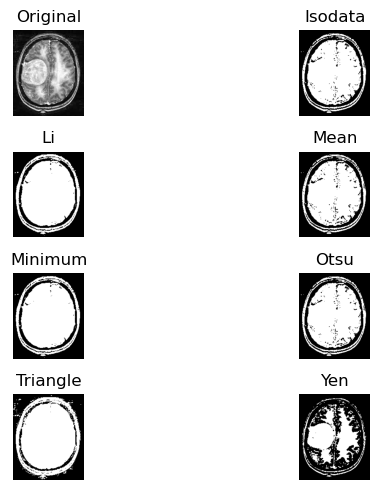

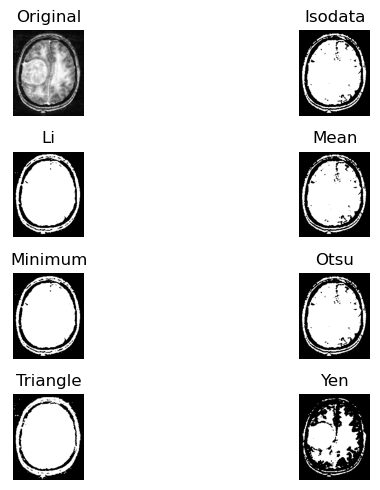

In [53]:
from skimage.filters import try_all_threshold, threshold_otsu
img = cv2.imread("Y1_gauss_clh.jpg", 0)
result = try_all_threshold(img)
img2 = cv2.imread("Y1_SP_clh.jpg", 0)
result2 = try_all_threshold(img2)

In [41]:
# find otsu's threshold value with OpenCV function
ret2,th2 = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
print( "{} {}".format(th2,ret) )

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] 127.0


In [ ]:
from skimage.morphology import disk
from skimage.filters import threshold_otsu, rank
from skimage.util import img_as_ubyte
radius = 15
footprint = disk(radius)

local_otsu = rank.otsu(img, footprint)
threshold_global_otsu = threshold_otsu(img)
global_otsu = img >= threshold_global_otsu

fig, axes = plt.subplots(2, 2, figsize=(8, 5), sharex=True, sharey=True)
ax = axes.ravel()
plt.tight_layout()

fig.colorbar(ax[0].imshow(img, cmap=plt.cm.gray),
             ax=ax[0], orientation='horizontal')
ax[0].set_title('Original')
ax[0].axis('off')

fig.colorbar(ax[1].imshow(local_otsu, cmap=plt.cm.gray),
             ax=ax[1], orientation='horizontal')
ax[1].set_title('Local Otsu (radius=%d)' % radius)
ax[1].axis('off')

ax[2].imshow(img >= local_otsu, cmap=plt.cm.gray)
ax[2].set_title('Original >= Local Otsu' % threshold_global_otsu)
ax[2].axis('off')

ax[3].imshow(global_otsu, cmap=plt.cm.gray)
ax[3].set_title('Global Otsu (threshold = %d)' % threshold_global_otsu)
ax[3].axis('off')

plt.show()

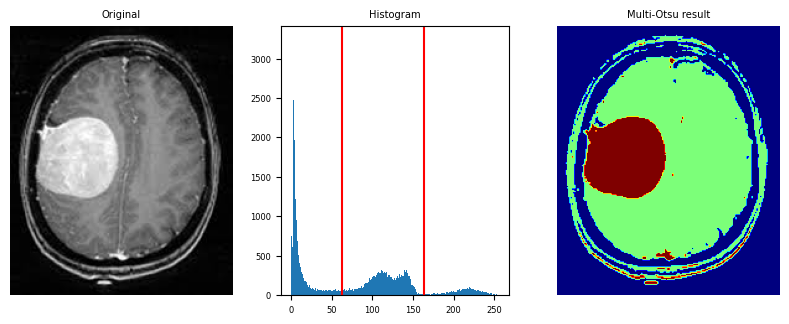

In [79]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from skimage import data
from skimage.filters import threshold_multiotsu
img = cv2.imread("Y1.jpg", 0)
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 6

# The input image.
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(img)
# Using the threshold values, we generate the three regions.
regions = np.digitize(img, bins=thresholds)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(img.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()

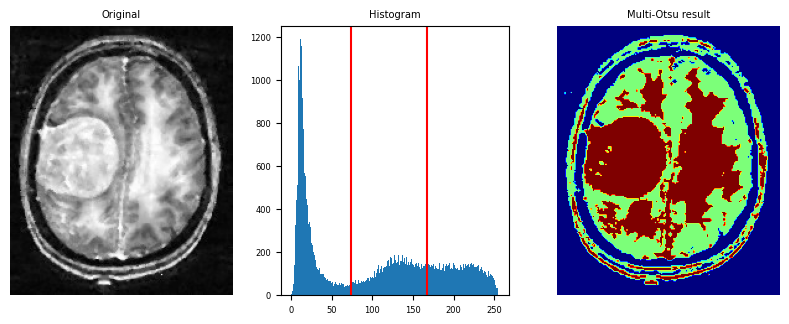

numpy.ndarray

In [77]:
img = cv2.imread("Y1_SP_clh.jpg", 0)
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 6

# The input image.
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(img)
# Using the threshold values, we generate the three regions.
regions = np.digitize(img, bins=thresholds)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
ax[1].hist(img.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()

plt.show()
plt.imsave('TEST.jpeg', regions,cmap='jet')
type(regions)

In [74]:
from PIL import Image

im = Image.fromarray(regions)

#cv2.imwrite('TEST_Fonc2.jpg',im)

TypeError: Cannot handle this data type: (1, 1), <i8

In [87]:
def threshold_segmentation(image):
  import matplotlib
  import matplotlib.pyplot as plt
  import numpy as np
  from skimage import data
  from skimage.filters import threshold_multiotsu
  thresholds = threshold_multiotsu(image)
  # Using the threshold values, we generate the three regions.
  regions = np.digitize(image, bins=thresholds)
  plt.imsave('TEST4.jpeg', regions,cmap='jet')
  return regions
String="Y1.jpg"
img = cv2.imread(String, 0)

threshold_segmentation(img)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [105]:
import os
def threshold_segmentation(image, file):
  import matplotlib
  import matplotlib.pyplot as plt
  import numpy as np
  from skimage import data
  from skimage.filters import threshold_multiotsu
  thresholds = threshold_multiotsu(image)
  # Using the threshold values, we generate the three regions.
  regions = np.digitize(image, bins=thresholds)
  plt.imsave(file+"_Seg.jpg", regions,cmap='jet')
  return regions
#file+"_Seg"
for filename in os.listdir("C:/Users/arthu/Desktop/test"):
  #print(filename)
  print(type(filename))
  img = cv2.imread("C:/Users/arthu/Desktop/test/"+filename, 0)
  threshold_segmentation(img, filename)


<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [91]:
print("V"+" "+"Segmented")

V Segmented
